<a href="https://colab.research.google.com/github/steniodeassis/outdoor-indoor-ml/blob/main/binary_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS156 \#2 Binary Classification Assignment**

Most of the previous assignments are preserved. However, some minor alterations were implemented based on the feedback.

In this assignment, we are increasing the dataset by augmenting it by flipping, cropping, and randomly assigning noise to the images. By expanding the dataset from 100 to 1100, we expect to increase the models' accuracy and train a generative model.

We also added ways to visualize the two classes by reducing the data using PCA, autoencoder, and clustering.

We observed better accuracy values for the Regression, KNN, and CNN, which I discussed in relation to the previous models.

## **Dataset**

When searching for "outdoors" in Google Photos, the application quickly displays images of parks, blue skies, and beaches. Similarly, searching for "indoors" yields images featuring ceilings, household objects, windows, and doors. I am interested in replicating this type of classification for my own photos using various machine learning binary classification models, and comparing their accuracy and efficiency.

I am working with a dataset of 100 photos: 50 labeled as "indoors" and 50 as "outdoors." These photos were taken over the past ten months in London, Scotland, Houston, Faro, Berlin, and San Francisco.

For the "indoors" label, I classified images taken under a roof, such as those inside planes or on terraces, or those with sufficient context to be recognized as indoor. The "outdoors" label included photos taken in open environments, like streets, building facades, and other exterior settings. To create a more diverse dataset, I also included images that lack clear cues but provide enough contextual information to update the model and improve its generalizability. The model will need to determine whether each image was captured indoors or outdoors, relying on macro cues like lighting, object types, shapes, colors, and shading.

To avoid overfitting and ensure the model's predictions aren't random, I will perform a 70-30 train-test split. Seventy percent of the data (70 photos) will be used for training, while the remaining 30% (30 photos) will be reserved for testing the model's performance.

The general pipeline for this project is detailed below.

## **Calling the dataset**

The images are stored in a Google Drive folder, with separate subfolders for "outdoors" and "indoors," each containing their respective images. In Google Colab, I use the `drive` package to connect this Colab notebook to my Google Drive content. This allows me to access the directory path of my images, referred to as `img_dir`. By using the function `load_images_with_labels(img_dir)`, I can convert each image into an array, with its corresponding label determined by the subfolder in which the image is located.

In [ ]:
!pip install pyheif Pillow
from PIL import Image
from google.colab import drive
import pyheif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# collect data (images) from my personal drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the dataset as classes as subfolders (classes: indoors/outdoors)
img_dir = '/content/drive/MyDrive/data_cs156'

In [ ]:
def load_images_with_labels(img_dir):
  '''
  Load the images into manageable format for the model.
  Preprocess the images (resize, normalize, etc.)
  Return the images and labels.

  input:
    img_dir: path to the folder containing the images.

  return:
    images: numpy array of the images.
    labels: numpy array (0 for outdoors, 1 for indoors)
  '''
  images = []
  labels = []
  for class_folder in os.listdir(img_dir):
    class_path = os.path.join(img_dir, class_folder)
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = Image.open(img_path)
      img = img.resize((256, 256)) # resize the images
      img_array = np.array(img) / 255.0 #normalize pixel values
      images.append(img_array)
      labels.append(0 if class_folder == 'outdoors' else 1)
  return np.array(images), np.array(labels)

images, labels = load_images_with_labels(img_dir)

## **Augmenting Dataset in 10x**

In [ ]:
import imgaug.augmenters as iaa

def augment_images(images, labels, target_count=1000):
    """
    Augment the dataset to increase the number of images.

    input:
        images: numpy array of original images.
        labels: numpy array of corresponding labels.
        target_count: target number of total images.

    return:
        aug_images: numpy array of augmented images.
        aug_labels: numpy array of corresponding labels.
    """
    # Convert to uint8 format
    images = (images * 255).astype(np.uint8)

    augmenter = iaa.Sequential([
        iaa.Fliplr(0.5),  # flip horizontally with 50% probability
        iaa.Affine(rotate=(-20, 20)),  # rotate within -20 to 20 degrees
        iaa.GaussianBlur(sigma=(0, 1.0)),  # apply Gaussian blur
        iaa.AddToHueAndSaturation((-10, 10)),  # adjust hue/saturation
        iaa.Multiply((0.8, 1.2)),  # adjust brightness
        iaa.Crop(percent=(0, 0.1)),  # random crop up to 10% of the image
    ])

    aug_images = []
    aug_labels = []

    while len(aug_images) < target_count:
        for i in range(len(images)):
            # Apply augmentations
            augmented = augmenter(image=images[i])
            aug_images.append(augmented)
            aug_labels.append(labels[i])
            if len(aug_images) >= target_count:
                break

    return np.array(aug_images), np.array(aug_labels)

# Step 3: Combine Original and Augmented Data
original_images, original_labels = load_images_with_labels(img_dir)
augmented_images, augmented_labels = augment_images(original_images, original_labels, target_count=1000)
augmented_images = augmented_images/255

# Combine the original and augmented datasets
final_images = np.concatenate((original_images, augmented_images), axis=0)
final_labels = np.concatenate((original_labels, augmented_labels), axis=0)

print(f"Final dataset size: {len(final_images)} images")


Final dataset size: 1100 images


In [ ]:
images, labels = final_images, final_labels

## **Pre-processing**

When I added the photos to my Drive folder, I expected to encounter images in different formats, as some were taken with my previous Android phone and the more recent ones with my iPhone, which often saves images in the HEIC format. Initially, I thought I would have to manually convert all images to a single format (e.g., JPG) to ensure consistency and ease of processing. In the `load_images_with_label()` function, I initially included a command that checked each image's format, and if it was HEIC, another function would be called to convert it to JPG using the `pyheif` and `PIL` packages.

However, I later encountered issues loading the data due to format discrepancies and realized that some of my images were duplicated as both JPG and HEIC. To resolve this, I deleted the HEIC images, keeping only the JPG files. This step not only eliminated the format errors but also reduced unnecessary duplication, noise, and the potential for overfitting, which ultimately helps improve the accuracy and generalizability of the model.

In addition to this, I resized each image to 256x256 pixels and normalized the pixel values by dividing them by 255, ensuring all pixel values fall within the range [0,1]. The output of this process is a 4-dimensional array, where each image (100 in total) is represented as an array of shape (256, 256, 3), with 3 values corresponding to the pixel intensity of the RGB (red, green, blue) channels.

Below, I display the first and last image samples of the dataset, along with descriptive statistics of the pixel intensity distribution.

For the code processing, outdoor images are labeled "0", the negative class; and indoor images are labeled "1", the positive class.

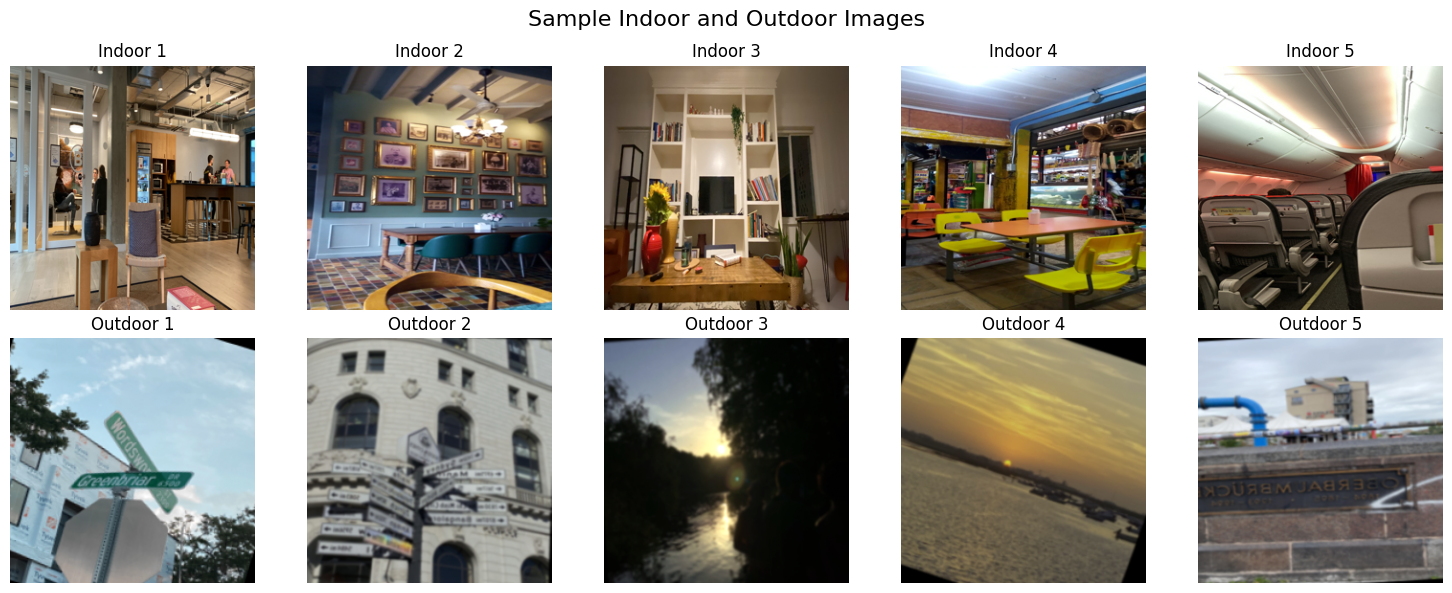

Shape of images array: (1100, 256, 256, 3)
Shape of labels array: (1100,)


In [ ]:
# Set up a 2x5 grid for the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

# First row: Indoor images
for i in range(5):
    axes[0, i].imshow(images[i])
    axes[0, i].grid(False)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Indoor {i+1}')

# Second row: Outdoor images
for i in range(5):
    axes[1, i].imshow(images[990 + i])
    axes[1, i].grid(False)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Outdoor {i+1}')

fig.suptitle('Sample Indoor and Outdoor Images', fontsize=16)

plt.tight_layout()
plt.show()

# Print the shape of the image and label arrays
print('Shape of images array:', images.shape)
print('Shape of labels array:', labels.shape)

## **Descriptive statistics**

In [ ]:
# Assuming 'images' is a numpy array with shape (num_images, height, width, channels)
# and 'labels' is a numpy array with the corresponding labels ('out' for outdoors, 'in' for indoors)

def show_image_stats(images, labels):
    '''
    Compute and display the descriptive stats for all class of images
    based on the pixel intensity distribution.

    input:
      images: numpy array of the images.
      labels: numpy array (0 for outdoors, 1 for indoors)
    return:
      None (print the stats)
    '''
    # Separate the images into outdoors and indoors
    outdoors_images = images[labels == 0]
    indoors_images = images[labels == 1]

    def compute_stats(imgs):
        '''
        Compute the descriptive stats for the images.

        input:
          imgs: the array of images

        return:
          stats_all_channels: the descriptive stats for all channels
          stats_per_channel: the descriptive stats for each channel
        '''
        # Flatten the image data for all images (combine all pixels into one big array)
        flat_images = imgs.reshape(-1, imgs.shape[-1])  # shape: (total_pixels, channels)

        # Compute stats for the full dataset (across all channels and images)
        stats_all_channels = {
            'Mean': np.mean(flat_images),
            'Median': np.median(flat_images),
            'Min': np.min(flat_images),
            'Max': np.max(flat_images),
            'Standard Deviation': np.std(flat_images)
        }

        # Compute stats for each channel (R, G, B)
        stats_per_channel = {}
        if imgs.shape[-1] == 3:  # Check if images are RGB
            for i, channel in enumerate(['Red', 'Green', 'Blue']):
                channel_data = flat_images[:, i]
                stats_per_channel[channel] = {
                    'Mean': np.mean(channel_data),
                    'Median': np.median(channel_data),
                    'Min': np.min(channel_data),
                    'Max': np.max(channel_data),
                    'Standard Deviation': np.std(channel_data)
                }
        return stats_all_channels, stats_per_channel

    # Compute stats for outdoors, indoors, and the whole dataset
    outdoor_stats_all, outdoor_stats_channel = compute_stats(outdoors_images)
    indoor_stats_all, indoor_stats_channel = compute_stats(indoors_images)
    total_stats_all, total_stats_channel = compute_stats(images)

    # Dataset shape info
    num_images = images.shape[0]
    height, width, channels = images.shape[1], images.shape[2], images.shape[3]

    print(f"Dataset Shape: {num_images} images of size ({height}x{width}) with {channels} channels.")

    # Display stats for outdoors
    print("\nOutdoors Pixel Statistics (across all images and channels):")
    print(pd.DataFrame(outdoor_stats_all, index=['Value']).T)
    if outdoor_stats_channel:
        print("\nOutdoors Per-Channel Pixel Statistics:")
        print(pd.DataFrame(outdoor_stats_channel).T)

    # Display stats for indoors
    print("\nIndoors Pixel Statistics (across all images and channels):")
    print(pd.DataFrame(indoor_stats_all, index=['Value']).T)
    if indoor_stats_channel:
        print("\nIndoors Per-Channel Pixel Statistics:")
        print(pd.DataFrame(indoor_stats_channel).T)

    # Display stats for total dataset
    print("\nTotal Dataset Pixel Statistics (across all images and channels):")
    print(pd.DataFrame(total_stats_all, index=['Value']).T)
    if total_stats_channel:
        print("\nTotal Dataset Per-Channel Pixel Statistics:")
        print(pd.DataFrame(total_stats_channel).T)

# Call the function to display stats for your dataset, assuming labels are 'out' for outdoors and 'in' for indoors
show_image_stats(images, labels)


Dataset Shape: 1100 images of size (256x256) with 3 channels.

Outdoors Pixel Statistics (across all images and channels):
                       Value
Mean                0.434263
Median              0.415686
Min                 0.000000
Max                 1.000000
Standard Deviation  0.271793

Outdoors Per-Channel Pixel Statistics:
           Mean    Median  Min  Max  Standard Deviation
Red    0.422229  0.407843  0.0  1.0            0.256226
Green  0.434415  0.423529  0.0  1.0            0.259317
Blue   0.446145  0.411765  0.0  1.0            0.297374

Indoors Pixel Statistics (across all images and channels):
                       Value
Mean                0.413342
Median              0.396078
Min                 0.000000
Max                 1.000000
Standard Deviation  0.243347

Indoors Per-Channel Pixel Statistics:
           Mean    Median  Min  Max  Standard Deviation
Red    0.455516  0.447059  0.0  1.0            0.244750
Green  0.417788  0.403922  0.0  1.0            0.23822

From the data statistics, we can observe that both the mean and standard deviation of the images pixel values are similar across channels and between the two classes (indoors and outdoors). The overall dataset mean is around 0.43, and the standard deviation is approximately 0.26. However, a notable difference emerges in the blue channel, which shows the highest standard deviation for outdoor images (around 0.30). This suggests a greater variability in blue intensity across the outdoor images, likely due to the presence of the sky, whose tone can vary depending on the time of day. Conversely, the blue channel exhibits the lowest mean for indoor images, indicating that blue tones are less prevalent in indoor settings, likely due to the absence or limited visibility of sky elements. While these differences are subtle, they provide valuable clues that the models can use to distinguish between the two classes.

% One approach to enhance these differences in the training data is to amplify them.

To visualize these patterns, we can plot the kernel density estimate (KDE) graphs for the combined pixel values of both indoor and outdoor images. KDE plots represent the data distribution as a continuous probability density curve, making it easier to compare different channels and categories, as they are less cluttered and more interpretable than traditional histograms.

The plot reveals some overlap between the two classes, but we also see that the outdoor class is more spread out around the mean, reflecting a greater variety of pixel intensities. This variety can be attributed to the diversity of colors and shades outdoors, which change throughout the day. On the other hand, the KDE for the indoor dataset is less dispersed, with a peak around 0.3 intensity. This suggests less variation in colors and shades in indoor images, likely due to the limited presence of natural light and the dominance of artificial colors and tones indoors.

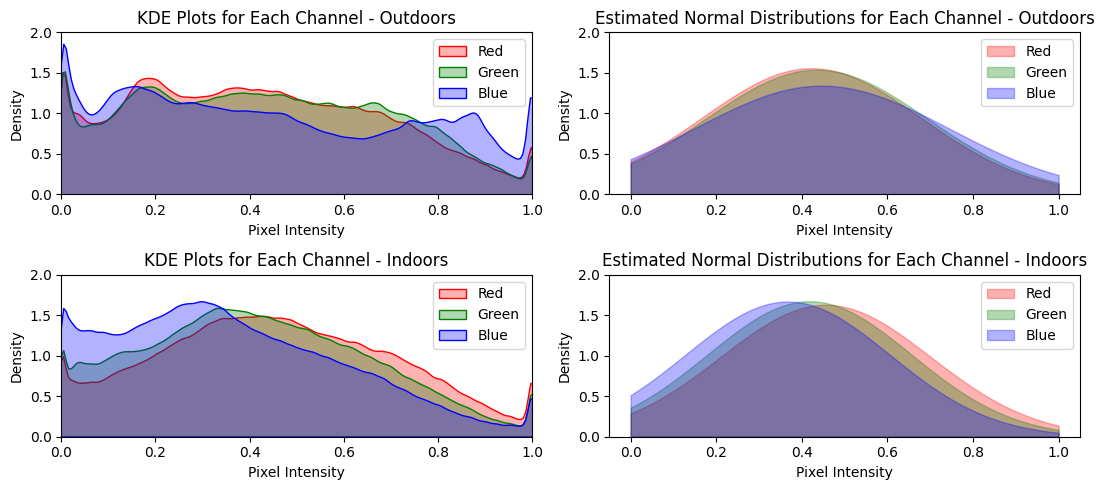

In [ ]:
from scipy.stats import norm

def plot_pixel_distribution_by_channel(images, labels):
    '''
    Plot the pixel distribution for each channel as KDE plots
    and compare it with the normal distribution.

    input:
      images: numpy array of the images.
      labels: numpy array (0 for outdoors, 1 for indoors)
    return:
      None (plot the data distribution)
    '''

    # Define colors for each channel
    channels = ['Red', 'Green', 'Blue']
    colors = ['r', 'g', 'b']

    # Separate the images into outdoors and indoors
    outdoors_images = images[labels == 0]
    indoors_images = images[labels == 1]

    plt.figure(figsize=(11, 5))

    ## OUTDOORS
    # Calculate mean and std for each channel
    out_means = outdoors_images.mean(axis=(0, 1, 2))
    out_stds = outdoors_images.std(axis=(0, 1, 2))

    # KDE plot
    plt.subplot(2, 2, 1)
    for i in range(3):  # For each channel
        # Flatten the pixel values for the channel
        flat_channel = outdoors_images[:, :, :, i].flatten()
        sns.kdeplot(flat_channel, color=colors[i], fill=True, alpha=0.3, label=f'{channels[i]}')

    plt.title('KDE Plots for Each Channel - Outdoors')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.ylim(0, 2)
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()

    # Normal
    plt.subplot(2, 2, 2)

    for i in range(3):  # For each channel
        # Create a range of pixel values
        xmin, xmax = 0, 1  # Normalized pixel values range
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, out_means[i], out_stds[i])  # Probability density function

        # Fill the area under the normal distribution curve
        plt.fill_between(x, p, color=colors[i], alpha=0.3, label=f'{channels[i]}')

    plt.title('Estimated Normal Distributions for Each Channel - Outdoors')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.ylim(0, 2)
    plt.legend()
    plt.tight_layout()

    ## INDOORS
    # Calculate mean and std for each channel
    in_means = indoors_images.mean(axis=(0, 1, 2))
    in_stds = indoors_images.std(axis=(0, 1, 2))

    # KDE
    plt.subplot(2, 2, 3)

    for i in range(3):  # For each channel
        # Flatten the pixel values for the channel
        flat_channel = indoors_images[:, :, :, i].flatten()

        # KDE Plot
        sns.kdeplot(flat_channel, color=colors[i], fill=True, alpha=0.3, label=f'{channels[i]}')

    plt.title('KDE Plots for Each Channel - Indoors')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.ylim(0, 2)
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()

    # Normal
    plt.subplot(2, 2, 4)

    for i in range(3):  # For each channel
        # Create a range of pixel values
        xmin, xmax = 0, 1  # Normalized pixel values range
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, in_means[i], in_stds[i])  # Probability density function

        # Fill the area under the normal distribution curve
        plt.fill_between(x, p, color=colors[i], alpha=0.3, label=f'{channels[i]}')

    plt.title('Estimated Normal Distributions for Each Channel - Indoors')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.ylim(0, 2)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot pixel distributions for each channel
plot_pixel_distribution_by_channel(images, labels)

By plotting the KDE alongside the estimated normal distribution, we can gain a deeper understanding of how the different channels are distributed across the dataset. As observed in the KDE plots, both the red and green channels exhibit similar distributions, while the blue channel shows greater variation between the two labels. For outdoor images, there is a peak in blue intensity around 0.9, which is expected due to the presence of high-intensity blue elements, such as the sky. This peak is less pronounced in the normal distribution plot, where we observe a lower variance, indicating that the dataset is more spread out.

In the indoor category, a similar pattern is seen in the red and green channels, but the blue distribution is shifted to the left, which is consistent with the normal distribution plot, where the mean is lower, though the variance remains comparable. This suggests that blue elements in indoor images typically have lower pixel intensities, reflecting their relative infrequency compared to outdoor images.

## **Dimensionality Reduction**

In order to better visualize the dataset, we will be able to reduce the data distribution to the components that most explain the variation in the data.

### PCA

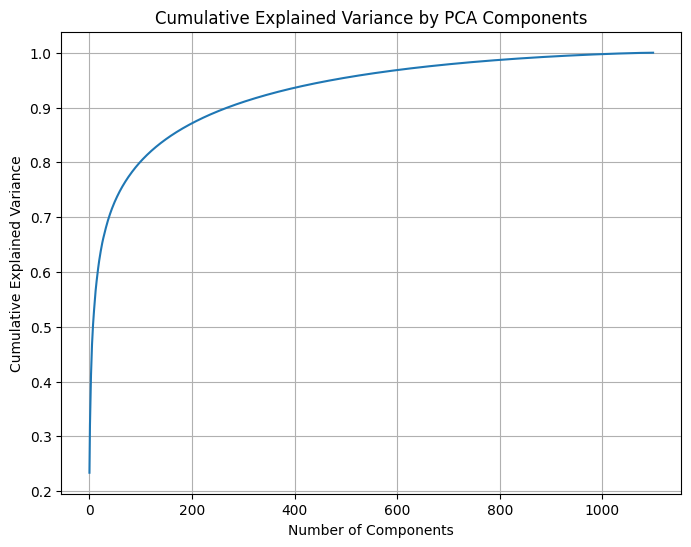

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Flatten the images for PCA
X = images.reshape(images.shape[0], -1)  # Reshaping (num_samples, 256*256*3)
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA and plot explained variance
pca = PCA()
pca.fit(X_scaled)

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Get 2D and 3D projections of the data
pca_2d = pca.transform(X_scaled)[:, :2]  # Use the first 2 components
pca_3d = pca.transform(X_scaled)[:, :3]  # Use the first 3 components


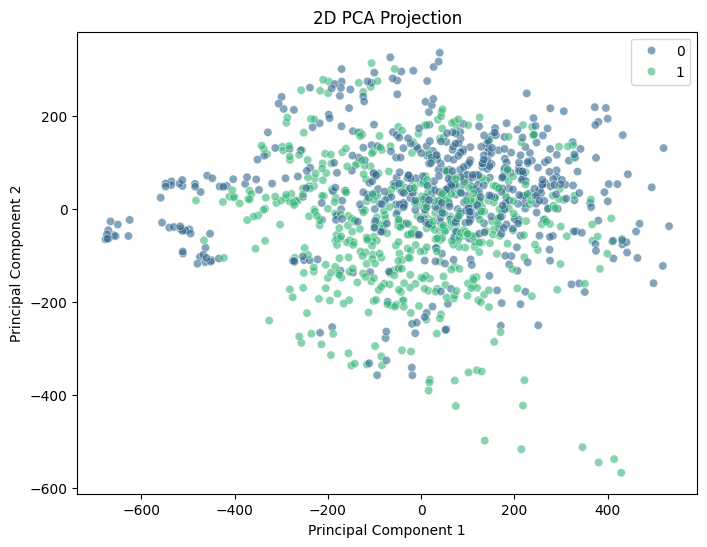

In [ ]:

# 2D plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, palette="viridis", alpha=0.6)
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



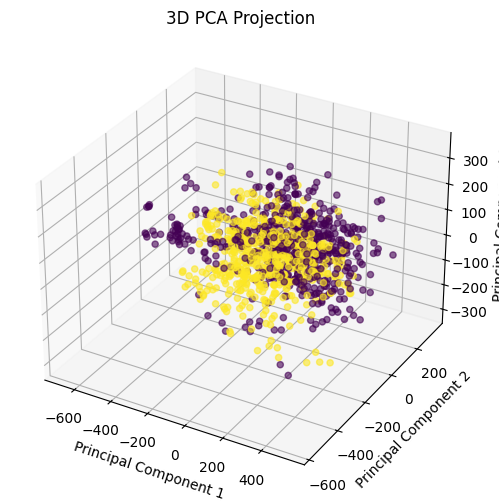

In [ ]:

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=labels, cmap='viridis', alpha=0.6)
ax.set_title('3D PCA Projection')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

Given that it is necessary more than 100 components to explaing 80% of variation in the data it is expected that the PCA projection do not separate the data in its entirely. The same can be true when autoencoders below.

### Autoencoder

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 440ms/step - loss: 0.0670 - val_loss: 0.0567
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0551 - val_loss: 0.0488
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0465 - val_loss: 0.0443
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0402 - val_loss: 0.0409
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0378 - val_loss: 0.0401
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0332 - val_loss: 0.0363
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0319 - val_loss: 0.0356
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0290 - val_loss: 0.0366
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0292 - val_loss: 0.0341
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0265 - val_loss: 0.0339
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


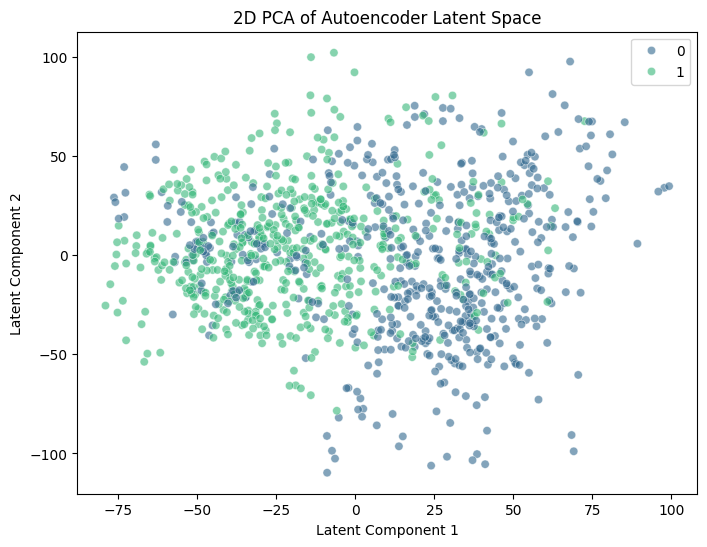

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

# Build the autoencoder model
input_img = Input(shape=(256, 256, 3))  # Input shape (256x256 RGB images)

# Encoder
x = Flatten()(input_img)
x = Dense(1024, activation='relu')(x)
encoded = Dense(256, activation='relu')(x)  # Latent space of 256 dimensions

# Decoder
x = Dense(1024, activation='relu')(encoded)
x = Dense(256 * 256 * 3, activation='sigmoid')(x)
decoded = Reshape((256, 256, 3))(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the autoencoder
autoencoder.fit(images, images, epochs=10, batch_size=32, validation_split=0.1)

# Extract the encoder part of the autoencoder
encoder = Model(input_img, encoded)

# Get the encoded representation for each image
encoded_imgs = encoder.predict(images)

# Plot the 2D latent space of the encoded images (we'll reduce it to 2D using PCA)
pca_latent = PCA(n_components=2).fit_transform(encoded_imgs)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_latent[:, 0], y=pca_latent[:, 1], hue=labels, palette="viridis", alpha=0.6)
plt.title('2D PCA of Autoencoder Latent Space')
plt.xlabel('Latent Component 1')
plt.ylabel('Latent Component 2')
plt.show()


Since autoencoders also do not separate the data as expected, we can use clustering for a better separation of the dataset.

### Clustering

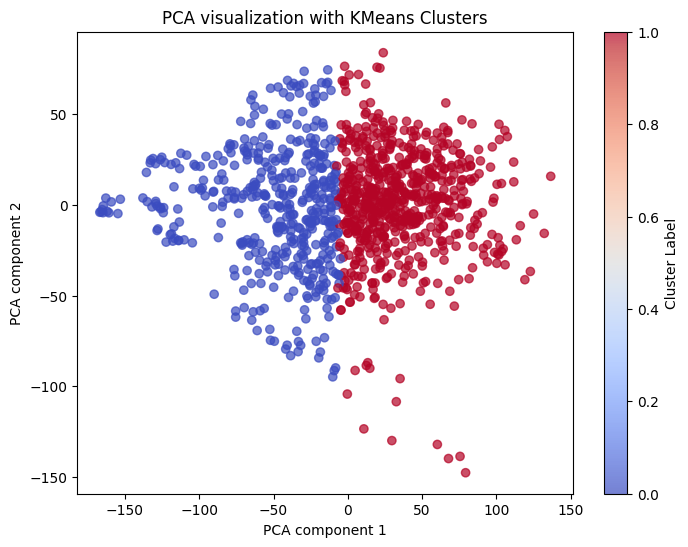

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Flatten the images to 1D arrays
images_flat = images.reshape(images.shape[0], -1)

# Apply KMeans clustering to classify the images into 2 clusters (outdoors vs indoors)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(images_flat)

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(images_flat)

# Plot the PCA result with clustering labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='coolwarm', alpha=0.7)
plt.title('PCA visualization with KMeans Clusters')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.colorbar(label='Cluster Label')
plt.show()


By clustering we can see how the data is splited.

## **Analysis and data splits**

This dataset will be used to train and evaluate three different models: logistic regression, KNN, and CNN. Since all of these models are suitable for binary classification tasks, we can compare their performance and determine which is best suited for this specific problem. The goal is to assess whether the models can accurately classify images as either "outdoors" or "indoors."

To achieve this, the data will be split into a training set (70%) and a test set (30%), with 770 images used for training and 330 for testing. This split allows the models to learn from a substantial portion of the data while still having enough unseen data for evaluation, ensuring the models' performance can generalize beyond the training set.

In [ ]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

In [ ]:
print('Shape of training images:', train_images.shape)
print('Shape of training labels:', train_labels.shape)
print('Shape of test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of training images: (770, 256, 256, 3)
Shape of training labels: (770,)
Shape of test images: (330, 256, 256, 3)
Shape of test labels: (330,)


## **Logistic Regression**

Logistic regression is a binary classification algorithm that uses the logistic function to estimate the probability that a given input belongs to one of two classes. It predicts whether data points belong to class 0 or class 1 based on a certain threshold, usually set to 0.5.

The model begins by calculating a linear combination of the input features and their corresponding weights:

$$z = w_1x_1+w_2x_2+\ ...\ +w_nx_n+b$$

Where $w_1+w_2, ..., w_n$ are the weights for each input feature $x_1, x_2, ..., x_n$; $b$ is the bias and $z$ is the result of the linear combination.

To compute the probability that a data point belongs to class 1, we apply the sigmoid (logistic) function as an activation function. The sigmoid function maps any real number to a value between 0 and 1:

$$P(y=1|x) = \sigma(w^Tx+b) = \sigma(z) = \frac{1}{1+e^{-z}}$$

If $\sigma(z)$ is closer to 1, the model predict the data point belongs to class 1, otherwise, the model predict class 0.

TThe model is improved by minimizing a loss function, which measures the error between the predicted probabilities and the true labels. In logistic regression, the log-loss (also known as binary cross-entropy) is used as the cost function:

$$\text{Loss}(y, \hat{y}) = -[y\cdot \log(\hat{y}) + (1-y)\cdot \log(1-\hat{y}]$$

where $y$ is the true label (either 0 or 1) and $\hat{y}$ is the predicted probabibility for class 1.

The total cost function for the model, averaged over all training examples, is:

$$J(w, b)=-\frac{1}{m} \sum_{i=1}^{m}\left[y^{(i)}\log(\hat{y}^{(i)}) + (1-y^{(i)})\log(1-\hat{y}^{(i)})\right]$$

where $m$ is the number of training examples.

To optimize the model, we use gradient descent to minimize the cost function. The partial derivatives of the cost function with respect to the weights $w_j$ and bias $b$ are computed as follows:

$$\frac{\partial J}{\partial w_j}=\frac{1}{m}\sum_{i=1}^m \left(\hat{y}^{(i)}-y^{(i)}\right)x_{j}^{(i)}$$
$$\frac{\partial J}{\partial b}=\frac{1}{m}\sum_{i=1}^m \left(\hat{y}^{(i)}-y^{(i)}\right)$$

The weights and bias are then iteratively updated as:
$$w_j=w_j-\alpha \frac{\partial J}{\partial w_j}$$
$$b=b-\alpha \frac{\partial J}{\partial b}$$

in which $\alpha$ is the learning rate, controling the step size of the gradient.

Once the model is trained, predictions for new data are made by computing the probability $\hat{y} = \sigma(z)$. If $\hat{y}>0.5$, the model predicts the positive class (1), otherwise, it predicts the negative class (0).


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# flatten images into 1d vectors
X_train_flat = train_images.reshape(train_images.shape[0], -1)
X_test_flat = test_images.reshape(test_images.shape[0], -1)

#fit model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_flat, train_labels)

LogisticRegression(max_iter=1000)

In [ ]:
#predict labels
y_pred = model.predict(X_test_flat)

#calculate accuracy
logistic_accuracy = accuracy_score(test_labels, y_pred)
print('Accuracy:', logistic_accuracy)

Accuracy: 0.8454545454545455


We get an accuracy of around 0.85, which is 1.2 times higher than the previous dataset of 100 images, which had accuract of 0.67.

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation (for example, k=5)
k = 5
scores = cross_val_score(model, X_train_flat, train_labels, cv=k, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracy for each fold: ", scores)

# Print the average accuracy across all folds
print("Average accuracy: ", np.mean(scores))

Accuracy for each fold:  [0.84415584 0.84415584 0.85064935 0.81818182 0.81168831]
Average accuracy:  0.8337662337662337


We see that for 5 splits of the training data, we get an average score of 0.83, which is still very high for a binary classification model. The model if the previous dataset of 100 images had accuracy of 0.8. This indicates that the increasing the number of images did not improve much the accuracy when not doing cross validation.

The `cross_val_score` only computes the accuracy for different splits of the training data, therefore it does not compute the accuracy for unseen data as seen in the Figure below.

Therefore the accuracy with the test dataset should not be neglected.

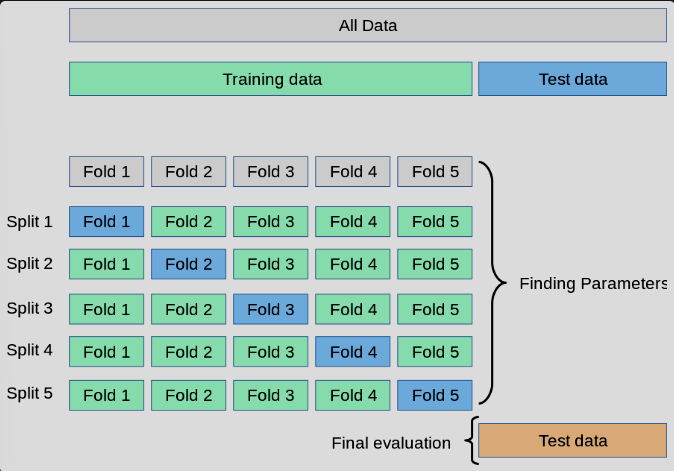

Figure 1: Cross-validation. From Scikit-learn.

We can also see how those values are distributed between the two classes, outdoors in indoors by visulizing the predictions in a confusion matrix.

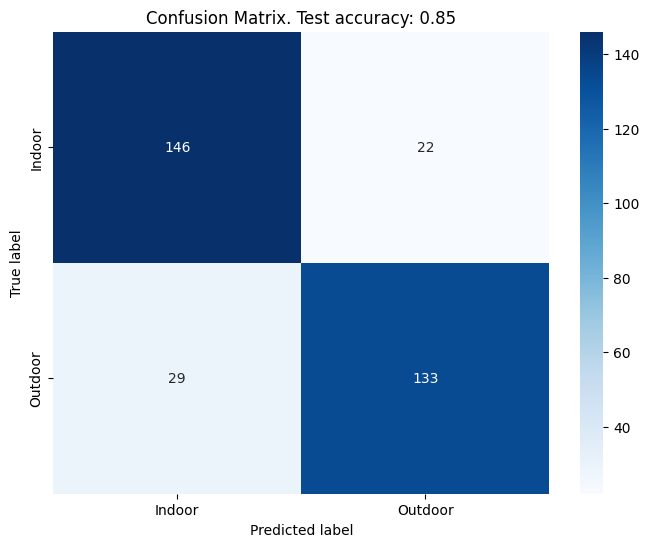

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrices
conf_matrix_test = confusion_matrix(test_labels, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, accuracy, title='Confusion Matrix.'):
    '''
    Plot the confusion matrix.

    Parameters:
    cm (numpy.ndarray): Confusion matrix.
    classes (list): List of class labels.
    accuracy (float): Accuracy of the model.
    title (str): Title of the plot.

    '''
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title+f' Test accuracy: {np.round(accuracy,2)}')
    plt.show()

# Plot confusion matrix for test data
plot_confusion_matrix(conf_matrix_test, classes=['Indoor', 'Outdoor'], accuracy=logistic_accuracy)

From this confusion matrix, we can see that the model does a great job predicting the correct labels, by predicting slightly better indoor images than outdoor images. We can see now compare this to the confusion matrices for the cross-validation.

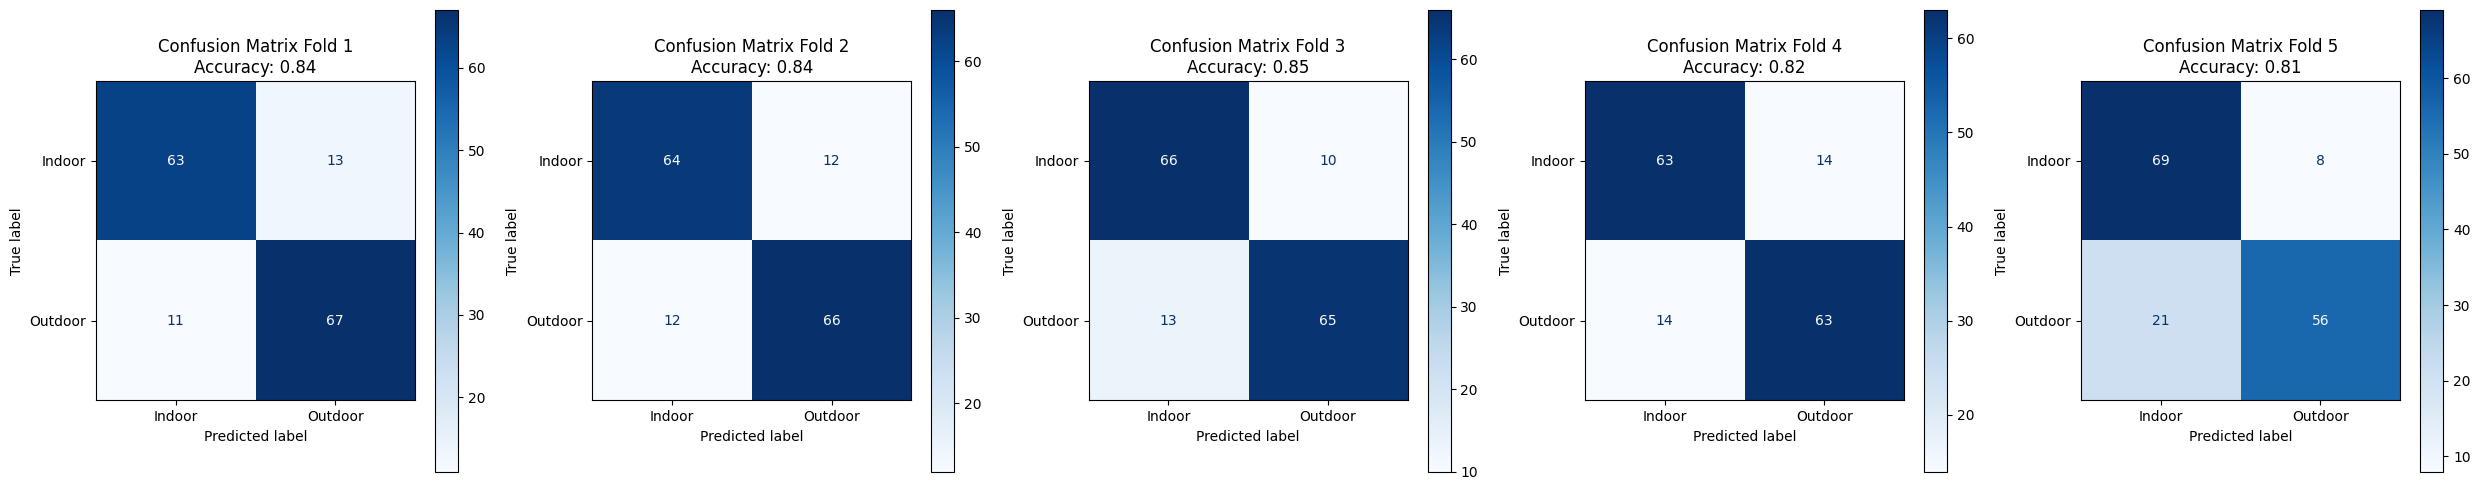

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Fit model using cross-validation
cv = StratifiedKFold(n_splits=5)
fold_accuracies = []

# List to store true and predicted labels for each fold
fold_true_labels = []
fold_predicted_labels = []

# Cross-validation loop
for train_index, val_index in cv.split(X_train_flat, train_labels):
    X_train_cv, X_val_cv = X_train_flat[train_index], X_train_flat[val_index]
    y_train_cv, y_val_cv = train_labels[train_index], train_labels[val_index]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_cv, y_train_cv)

    y_val_pred = model.predict(X_val_cv)

    # Append true and predicted labels for this fold
    fold_true_labels.append(y_val_cv)
    fold_predicted_labels.append(y_val_pred)

    # Store accuracy for each fold
    fold_accuracies.append(accuracy_score(y_val_cv, y_val_pred))

# Plot confusion matrix for each fold in a single figure
fig, axes = plt.subplots(1, 5, figsize=(25,5))  # Adjust to desired number of rows/columns

for fold in range(len(fold_true_labels)):
    cm_fold = confusion_matrix(fold_true_labels[fold], fold_predicted_labels[fold])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_fold, display_labels=['Indoor', 'Outdoor'])

    # Plot on the corresponding subplot
    disp.plot(ax=axes[fold], cmap=plt.cm.Blues, values_format='d')
    axes[fold].set_title(f'Confusion Matrix Fold {fold + 1}\nAccuracy: {fold_accuracies[fold]:.2f}')

plt.tight_layout()
plt.show()


A common metric to evaluate model performance is accuracy, which computes the ratio of true positives (TP) and true negatives (TN) compared to all predicted labels (TP, TN, false positives (FP), and false negatives (FN)). It shows how well the model correctly classifies data into the correct categories.

$$\text{accuracy}=\frac{\text{TP + TN}}{\text{TP + FP + TN + FN}}$$

In our case, we are interested in how well the model classifies images as either outdoors or indoors, so both classes are equally important. Since the classes have the same number of samples, preventing data imbalance, accuracy is a suitable metric. However, in situations where the data is imbalanced or one class is more important than the other, we can use other metrics such as precision, recall, and F1-score.

**Precision** is the ratio of correctly predicted positive classes to all instances predicted as positive. It is useful when false positives are more critical than false negatives.

$$\text{precision}=\frac{\text{TP}}{\text{TP + FP}}$$

**Recall** is the ratio of correctly predicted positive classes to all actual positive instances. It is a good metric when false negatives are more significant than false positives.

$$\text{recall}=\frac{\text{TP}}{\text{TP + FN}}$$

Precision and recall have a tradeoff: increasing one often decreases the other when adjusting the prediction threshold. In such cases, the **F1-score** can be used. The F1-score combines precision and recall into a single metric by calculating their harmonic mean.

$$\text{F1-score}=\frac{2\cdot\text{Precision}\cdot{\text{Recall}}}{\text{Precision + Recall}}=\frac{\text{TP}}{{\text{TP}+\frac{1}{2}\text{(FP+FN)}}}$$

We compute those metric below.

In [ ]:
from sklearn.metrics import classification_report
class_report = classification_report(test_labels, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       168
           1       0.86      0.82      0.84       162

    accuracy                           0.85       330
   macro avg       0.85      0.85      0.85       330
weighted avg       0.85      0.85      0.85       330



The model performs very well! Cross-validation highlights the model's ability to classify images across different splits of the training data, providing a more reliable estimate of its performance.

We plot the ROC-AUC curve for the logistic regression model to analyze the trade-off between sensitivity (true positive rate) and specificity (false positive rate) across various classification thresholds. The logistic regression model demonstrates good performance as the ROC curve bows towards the upper left corner, indicating high sensitivity and low false positive rates. Additionally, the AUC score of 0.89, which is above 0.50, suggests that the model is better than random chance at distinguishing between the classes.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


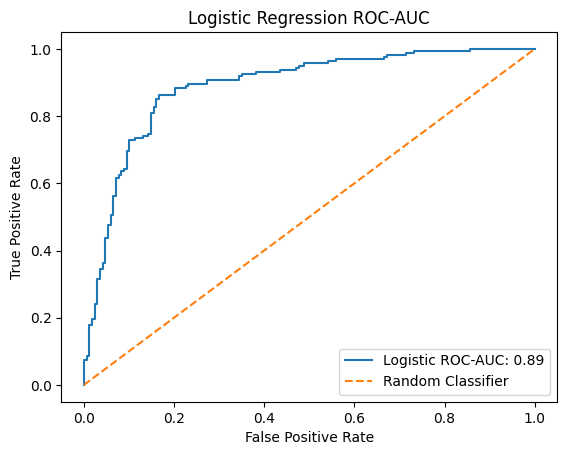

In [ ]:
from sklearn import metrics

# Calculate ROC-AUC
linear_preds = model.predict_proba(X_test_flat)[:, 1]

linear_curve = metrics.roc_curve(test_labels, linear_preds)

plt.plot(linear_curve[0], linear_curve[1], label="Logistic ROC-AUC: %.2f" % metrics.roc_auc_score(test_labels, linear_preds))
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.title("Logistic Regression ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## **KNN**

The K-Nearest Neighbors (KNN) algorithm is a classification method that predicts the class label of a query point by identifying the k-nearest points in the training data and then selecting the label with the majority vote among these neighbors. The algorithm relies on calculating the distance between data points.

To measure the distance, we use the Euclidean distance, which is computed between a query point $x=(x_1, x_2, x_3, \dots, x_n)$ and each training point $x^{(i)}=(x^{(i)}_1, x^{(i)}_2, x^{(i)}_3, \dots,x^{(i)}_n)$ in an n-dimensional space.

$$d(x, x^{(i)})=\sqrt{\sum_{j=1}^{n}(x_j-x^{(i)}_j)^2}$$

Once the distances are computed, we sort them, select the k-nearest neighbors, and count the number of neighbors belonging to each class. For binary classification, the predicted class is determined by:

$$\text{Predicted Class} = \arg\max_{c\in \{0, 1\}}\sum_{i=1}^{k}\mathbb{I}(y^{(i)}=c)$$

where $\mathbb{I}(y^{(i)}=c$ is an indicator function equal to 1 if the neighbor $y^{(i)}$ belongs to class $c$ and 0 otherwise.

The value of the hyperparameter $k$ (number of neighbors) significantly affects the performance of the KNN algorithm. A small $k$ can lead to sensitive model to noise (high variance) which may cause overfitting. A larger $k$ smooths the decision boundary but can introduce bias, potentially causing underfitting

For the images dataset, $k=5$ is chosen to strike a balance between overfitting and underfitting. Additionally, $k$ is often chosen to be odd to avoid ties when voting between class labels.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flat, train_labels)

KNeighborsClassifier()

In [ ]:
# Predictions
knn_predictions = knn_model.predict(X_test_flat)

# Calculate accuracy
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print('Accuracy with KNN:', knn_accuracy)

Accuracy with KNN: 0.8575757575757575


The KNN model achieves an accuracy of approximately 0.85, which is higher than the previous trained model with 100 images, which accuracy is 0.77. The KNN model has a slightly better accuracy than the logistic regression model. To gain a more comprehensive understanding of the overall model performance, we will compute the accuracy across multiple random data splits.

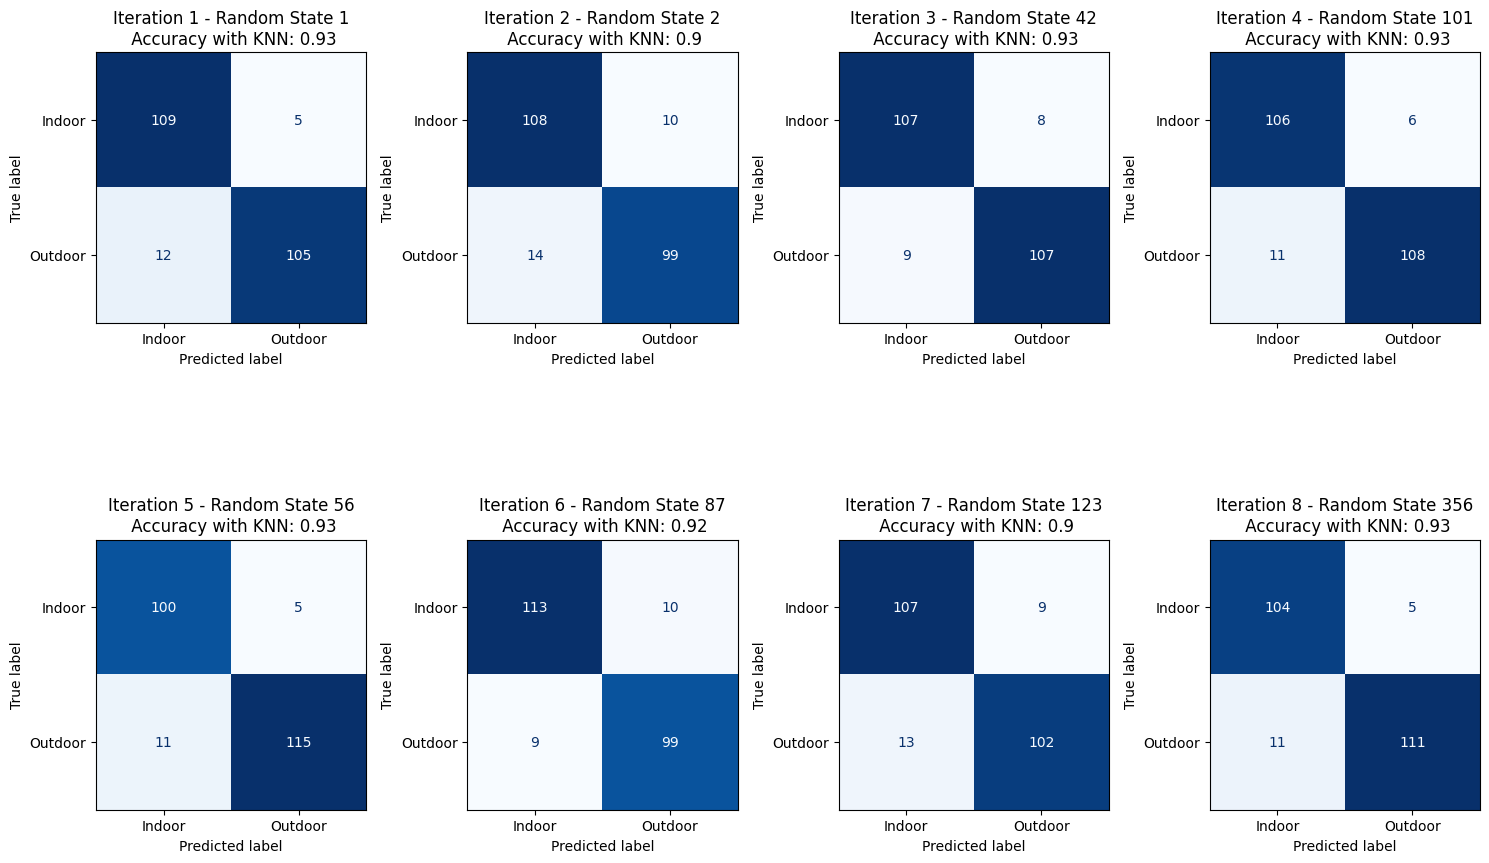

In [ ]:
# Define a list of random states for reproducibility
random_states = [1, 2, 42, 101, 56, 87, 123, 356]
num_partitions = len(random_states)

# Set up grid for confusion matrices
nrows = 2
ncols = (num_partitions + 1) // nrows  # Adjusting the number of columns based on partitions
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, rand_state in enumerate(random_states):
    # Randomly split the dataset into training and test sets using the specified random state
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_flat, train_labels, test_size=0.3, random_state=rand_state
    )

    # Train the KNN model
    knn_model_split = KNeighborsClassifier(n_neighbors=5)
    knn_model_split.fit(X_train, y_train)

    knn_predictions_split = knn_model.predict(X_test)

    # calculate accuracy
    knn_accuracy = accuracy_score(y_test, knn_predictions_split)
    cm = confusion_matrix(y_test, knn_predictions_split)

    # Plot confusion matrix in the corresponding grid position
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Indoor', 'Outdoor'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')  # Plot without a colorbar to save space
    ax.set_title(f'Iteration {i + 1} - Random State {rand_state}\n Accuracy with KNN: {np.round(knn_accuracy,2)}')

# Adjust layout
plt.tight_layout()
plt.show()


We can see that for random splits, the accuracy is always above 0.9, indicating the robustness of the model in predicting the right class.

We will apply here the same metrics as before.

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       168
           1       0.88      0.82      0.85       162

    accuracy                           0.86       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.86      0.86       330



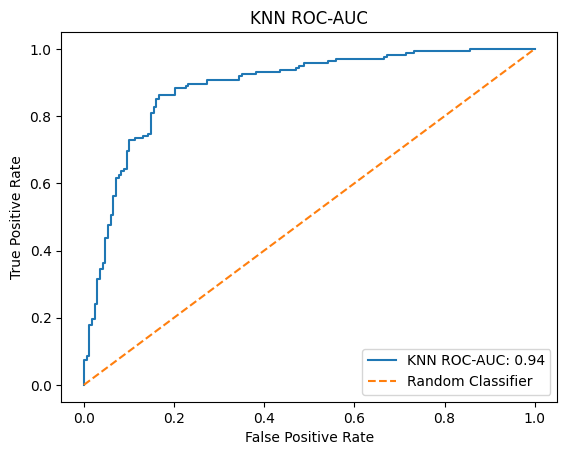

In [ ]:
# Compute Classification Report
class_report = classification_report(test_labels, knn_predictions)
print("Classification Report:\n", class_report)

# Calculate ROC-AUC
knn_preds = knn_model.predict_proba(X_test_flat)[:, 1]

knn_curve = metrics.roc_curve(test_labels, linear_preds)

plt.plot(knn_curve[0], knn_curve[1], label="KNN ROC-AUC: %.2f" % metrics.roc_auc_score(test_labels, knn_preds))
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.title("KNN ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Here we confirm that the KNN performs better as a binary classification for indoor and outdoor images than the logistics regression model, since we have overall higher scores and a better ROC curve for different thresholds.

## **CNN**

We can explore whether using a Convolutional Neural Network (CNN) results in higher accuracy for classifying images. CNNs are specifically designed for processing grid-like data such as images, making them more efficient compared to Artificial Neural Networks (ANNs). In an ANN, flattening image inputs requires a large number of tunable weights, which can increase computational demand.

CNNs, on the other hand, are more efficient at identifying patterns in images due to their use of convolution operations. These operations leverage the correlation between nearby pixels, allowing the model to better capture spatial hierarchies in the data. CNNs also reduce the number of input nodes and are more robust to small shifts in pixel positions.

In a standard ANN, the input image is flattened into a 1-dimensional vector before being fed into a hidden layer. Each hidden layer neuron applies a weighted sum of the inputs and a bias term before passing the result through an activation function, typically ReLU (Rectified Linear Unit):

$$z_j^{(l)}=\sum_{i=1}^n w_{ij}^{(l)}x_i+b_j^{(l)}=\textbf{w}_j^{(l)}\cdot \textbf{x}+b_j^{(l)}$$

where $w_j={ij}^{(l)}$ are the weights connecting neuron $j$ in layer $l$ to the $i$-th input, $b_j^{(l)}$ is the bias term for neuron $j$ in layer $l$, and $z_j^{(l)}$ is the weighted sum for neuron $j$ in layer $l$. The neuron applied an activation function $\sigma$ to $z_j^{(l)}$. The activation is sually a Relu function.

$$\text{ReLu}(z)=\max(0, z)$$

After passing the data through hidden layers, the output layer for binary classification typically uses the sigmoid activation function to produce a probability:

$$y_{\text{pred}} = \sigma(z^{(L)})=\frac{1}{1+e^{-z^{(L)}}}$$

where $z^{(L)}$ is the pre-activation value in the output layer.

After this, we would measure the error between the predicted output and the true label by using a loss function. For binary classification, the cross-entropy is used again.

$$\mathcal{L}=-\frac{1}{m}\sum_{i=1}^{m}\left(y_i\log(y_{\text{pred}}^{(i)}) +(1-y_i)\log(1-y_{\text{pred}}^{(i)})\right)$$

where $y_i$ is the true label and $y_{\text{pred}}^{(i)}$ is the predicted probability. We train the model by doing backpropagation. The network adjusts its weights and biases using the gradient descent. We use the chain rule to compute the derivative of the loss function with respect to each weight.

$$\frac{\partial\mathcal{L}}{\partial w_{ij}^{(l)}}=\frac{\partial\mathcal{L}}{\partial a^{(L)}}\cdot\frac{\partial a^{(L)}}{\partial z^{(L)}}\cdot\cdots\cdot\frac{\partial a^{l}}{\partial z^{(l)}}\cdot\frac{\partial z^{(l)}}{\partial w_{ij}^{(l)}}$$

The gradient descent update is done:

$$w_{ij}^{(l)}\leftarrow w_{ij}^{(l)}-\mu\cdot\frac{\partial\mathcal{L}}{\partial w_{ij}^{(l)}}$$

where $\mu$ is the model learning rate, a hyperparameter.

Our goal would be to chose the appropriate parameters that minizimze the cost function by computing the gradient descent of the function, similar to what we demonstraded for the logistics regression.

However, a CNN adds more step before we could feed an activation function. The core mathematimal operation in a CNN is the convolution.  If the input is an image represented as a 2D matrix $I$ and the filter is represented a $K$. The convultion of $I$ and $K$ is computed as:

$$(I*K)(i, j)=\sum_{m=1}^{m}\sum_{n=1}^{n}I(i+m, j+n)\cdot K(m,n)$$

where $k\times k$ is the size of the filter (kernel), $I(i+m, j+n)$ represents the pixel value of the input image at position (i+m, j+n). The result is the dot prouct between the kernel and a local region of the input as visualized in the image below. The output is a feature map, which highlights certain patterns based on the filter. At beginning, the filter is a grid of random values refined after training.




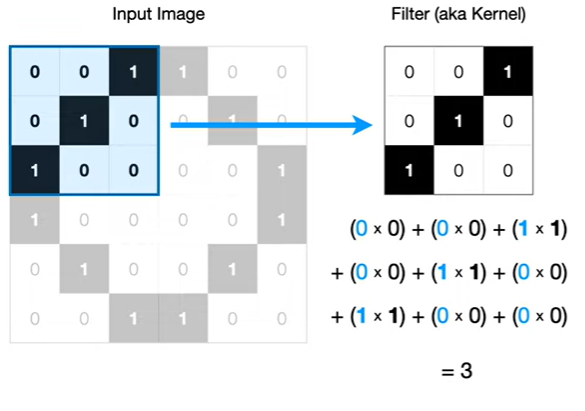


Figure 2: Filter application in a CNN. From StatQuest with Josh Starmer.

We compute a grid, called a Feature Map for all dot products for each combination between the input data and the filter. The feature map helps to identify correlations that exist in the image.

We run the feature map into a ReLu activation function, indicating that every negative value is set to zero, all positive values are kept. Now we apply another filter to the post-ReLu feature map, in this case we prevent overlap. The filter now takes the maximum value in each region as shown in Figure 4. This is called Max Pooling. The pooling layers are used to reduce the spatial dimension of the feature maps. Max-pooling takes the maximum value from the sub-region of the feature map.

$$S_{\text{pool}}(i, j)=\max_{m,n}S(i+m,j+n)$$,

where $S(i,j)$ is the output of the convolution at position $(i,j)$ and $(m,n)$ are the indices of the kernel.

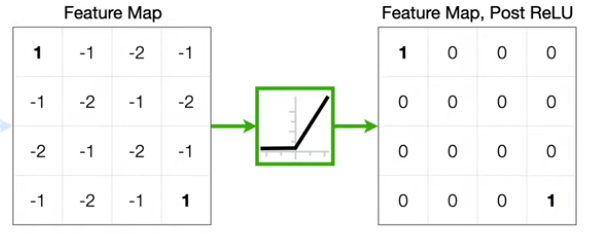

Figure 3: Feature Map input into ReLU function. From StatQuest with Josh Starmer.

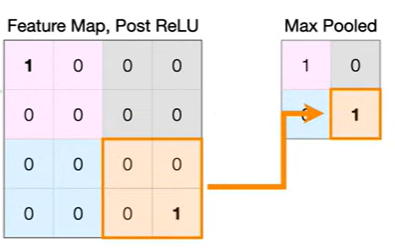

Figure 4: Max Pooling the Post-ReLU feature map. From StatQuest with Josh Starmer.

Now the values of the max pooled is input to a neural network. From here the process is the same as in a ANN. We multiply each input value with the associated weights and add the bias (computed by backpropagation). Then we input the value into a ReLU activation function in which the difference between the expected and the predicted value will be minimized to compute all the associate weights and biases.

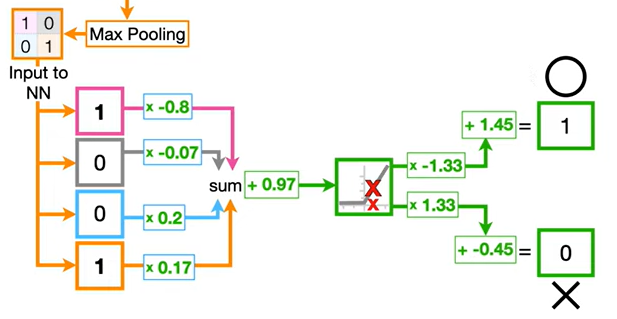

Figure 5: Max pooling input into NN and used to classify the image. From StatQuest with Josh Starmer.

In the following code, we implement a simple CNN model for our classification problem. We use the Keras Sequential API to train the model. The convolutional base uses an altenate pattern between Conv2D and MaxPooling2D layers. The CNN takes tensors as input of shape `(image_height, image_width, color_channels)`. The dimensions tend to shrink over layers. For the evaluation we are computing both the accuracy of the model by fiting the training data and the evaluation accuracy by separating 20% of the training data to be the evaluation set. In each epoch we adjust the parameters of the model with the same training data but shuffled so that the model is generalizeble for unseen data.

In [ ]:
import tensorflow as tf
# from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Binary classification (indoors/outdoors)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.5598 - loss: 1.3636 - val_accuracy: 0.6883 - val_loss: 0.5637
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7391 - loss: 0.5189 - val_accuracy: 0.7532 - val_loss: 0.4561
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8210 - loss: 0.4261 - val_accuracy: 0.9091 - val_loss: 0.2690
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8994 - loss: 0.2751 - val_accuracy: 0.8571 - val_loss: 0.2861
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9081 - loss: 0.2451 - val_accuracy: 0.9091 - val_loss: 0.2229
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9417 - loss: 0.1681 - val_accuracy: 0.9675 - val_loss: 0.1306
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9569 - loss: 0.1184 - val_accuracy: 0.9416 - val_loss: 0.1381
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9645 - loss: 0.1250 - val_accuracy: 0.9610 -

Bellow we can see how the model shrinks the dimensions of the data for each layer, as it was explained during the process of convolution and pooling. It starts with size (254, 254, 32) and finishes with size (128) and then (1), since at the end we want to know if the model can classify at least one class correctly.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,517,317 (169.82 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,678,212 (113.21 MB)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9349 - loss: 0.1097
Test Accuracy: 0.9364


We get an accuracy of 0.94, which is good compared to out training data size.
The previous accuracy for when the dataset was of 100 images was of 0.70. Then we see an improvement of 132% after augmenting the data in 10 times.


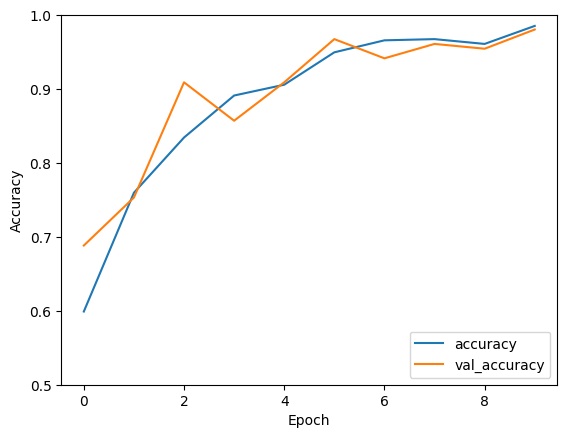

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see that the accuracy improves for few epoches.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       168
           1       0.95      0.91      0.93       162

    accuracy                           0.94       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.94      0.94      0.94       330

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


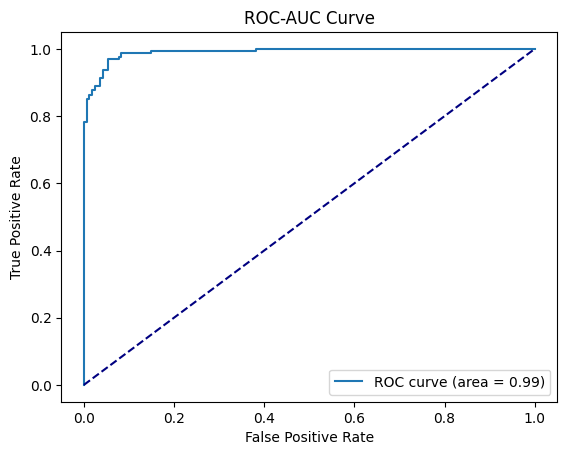

In [ ]:
predictions = (model.predict(test_images) > 0.5).astype("int32")  # Binary predictions (threshold = 0.5)

# Compute the classification report
class_report = classification_report(test_labels, predictions)
print("Classification Report:\n", class_report)

# Predict probabilities for ROC-AUC curve
probs = model.predict(test_images).ravel()  # Get probability values (flattened)

# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(test_labels, probs)
roc_auc = roc_auc_score(test_labels, probs)

# Plot ROC-AUC curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.show()

A ROC-AUC of 0.99 indicates that the model is very strong to predict the correct classes.

## **Executive summary**

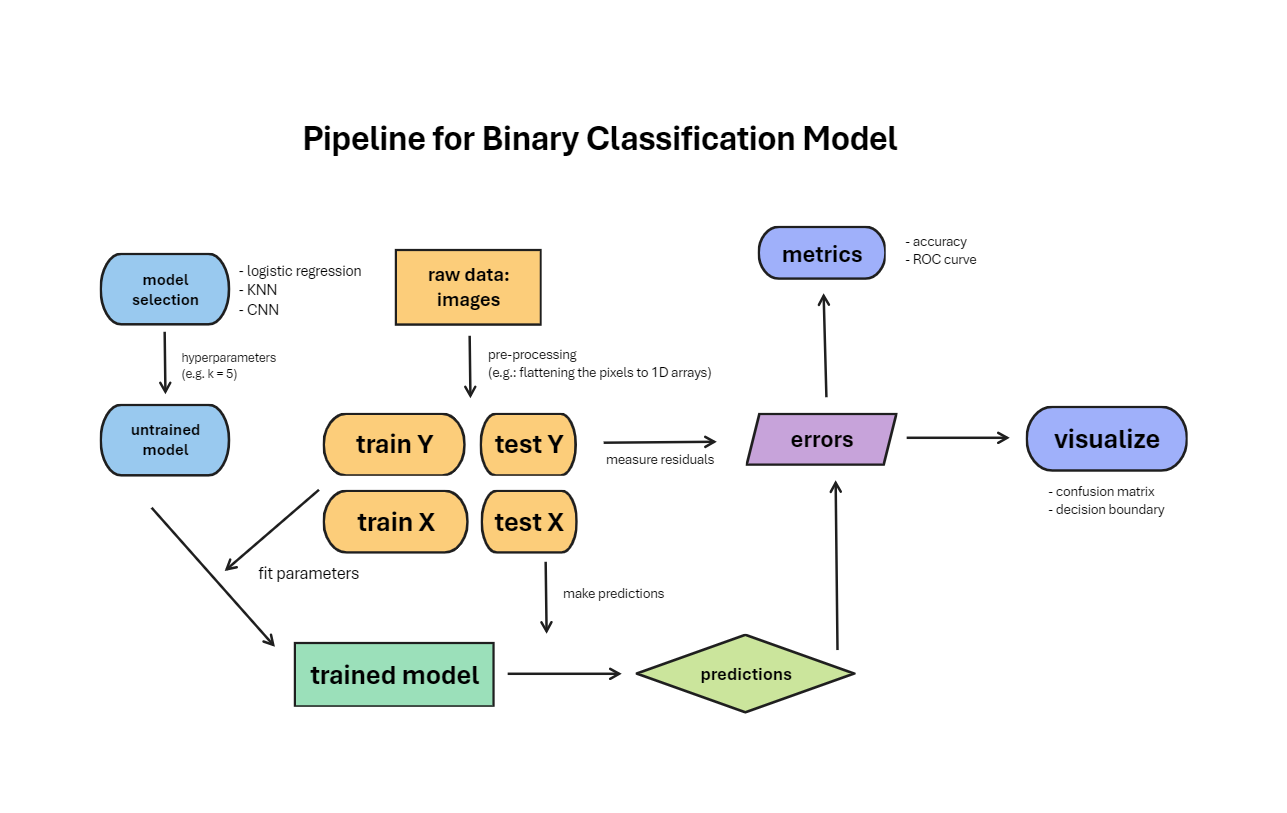

As discussed in the descriptive statistics session, one potential way to improve the model’s performance is to amplify the differences in the per-channel pixel statistics of the training data. While the RGB channels exhibit similar overall characteristics, we observed that the blue channel serves as a useful indicator for distinguishing between indoor and outdoor images. Specifically, the outdoor images tend to show a higher variance in the blue channel, likely due to the presence of varying intensities of blue, especially from the sky at different times of the day. In contrast, the indoor dataset generally has a lower mean intensity of blue, reflecting the limited presence of blue elements such as the sky in indoor environments.

By increasing the number of images we managed to increase the accuracy of all the models. However, augmenting the dataset is a paliative way to increase the dataset, we still need new data for the evaluation of the models. It could be the case the model is only good for images with the same features as the ones in which it was trained for, which does not mean the model can predict any image as being taken indoors or outdoors.

## **References**

Brownlee, J. (2023, October 4). A Gentle Introduction to k-fold Cross-Validation. Machine Learning Mastery. https://machinelearningmastery.com/k-fold-cross-validation/

Daniel, J., & Martin, J. (2023). Speech and Language Processing. https://web.stanford.edu/~jurafsky/slp3/5.pdf

Pandey, A. (2021, January 8). The Math Behind KNN. Medium. https://ai.plainenglish.io/the-math-behind-knn-7883aa8e314c

Rai, K. (2020, June 14). The math behind Logistic Regression. Medium. https://medium.com/analytics-vidhya/the-math-behind-logistic-regression-c2f04ca27bca

Starmer, J. (2021, March). Neural Networks Part 8: Image Classification with Convolutional Neural Networks. Youtube; StatQuest. https://www.youtube.com/watch?v=HGwBXDKFk9I

TensorFlow. (2019). Convolutional Neural Network (CNN)  |  TensorFlow Core. TensorFlow. https://www.tensorflow.org/tutorials/images/cnn

Verma, M. (2022, May 8). Binary Classification Using Convolution Neural Network (CNN) Model. Medium. https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb

Wilber, J. (n.d.). Train, Test, and Validation Sets. MLU-Explain. https://mlu-explain.github.io/train-test-validation/

Wilber, J. (2022a, March). Precision and Recall. MLU-Explain. https://mlu-explain.github.io/precision-recall/

Wilber, J. (2022b, June). ROC and AUC. MLU-Explain. https://mlu-explain.github.io/roc-auc/